# Classification

In [1]:
#!/usr/bin/env python3

# Basic import
import numpy as np
import matplotlib.pyplot as plt

# Pytorch import
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, Subset
from torchvision import transforms, datasets
import torch.nn.functional as F

# Import models and training functions
from models import ConvNet, FFNet
from training import train_epochs, train_epochs_acc, kf_train_epochs
from functions import my_accuracy

# Import progress bars
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from time import sleep

# Optuna
import optuna
from optuna.visualization import plot_parallel_coordinate, plot_param_importances, plot_contour


#Import sys
import sys





## Dataset and Dataloader

In [2]:
### Dataset

dataset = datasets.MNIST('MNIST', train = True, download = True,
                             transform = transforms.Compose([
                               transforms.ToTensor(),
                                transforms.Normalize(0.0, 1.0, inplace=True)
                             ]))

test_data = datasets.MNIST('MNIST', train = False, download = True,
                             transform=transforms.Compose([
                               transforms.ToTensor(),
                                 transforms.Normalize(0.0, 1.0, inplace=True)
                             ]))

# Divide data dataset in train dataset and val dataset
train_data, val_data = torch.utils.data.random_split(dataset, [50000, 10000])

In [3]:
### Dataloaders
batch_size = 128
train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers=0)
val_dataloader = DataLoader(val_data, batch_size = batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size = 1, shuffle=True, num_workers=0)

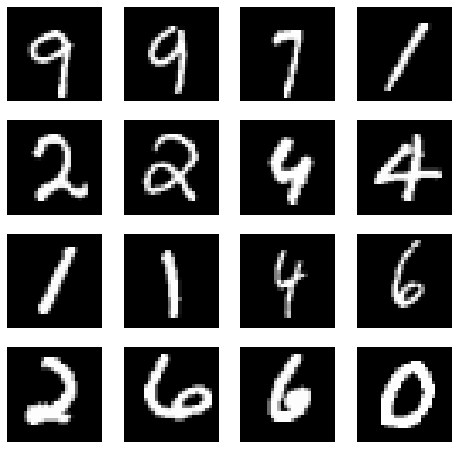

In [4]:
# Plot Mnist
figure = plt.figure(figsize=(8, 8))
cols, rows = 4,4


for i in range(1,cols * rows+1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Training

In [5]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


### Stocahstic Gradient Descent

In [ ]:
# Define the networks
filename = "ConvNet_sgd.torch"
parameters = {
    "act" : nn.ReLU, 
    "drop_p" : 0.1,
}

# Inizialize the network
torch.manual_seed(0)
net = ConvNet(parameters)
net.to(device)

In [ ]:
# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.0, weight_decay = 0.0)

# Training 
max_num_epochs = 20
early_stopping = False
train_loss_sgd, val_loss_sgd, accuracy_sgd = train_epochs_acc(net, device, train_dataloader, val_dataloader, test_dataloader, loss_function, optimizer, max_num_epochs, early_stopping = early_stopping)

In [ ]:
### Plot losses
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax1.semilogy(train_loss_sgd, label='Train loss')
ax1.semilogy(val_loss_sgd, label='Validation loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.semilogy(accuracy_sgd, label = "Test accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Test accuracy (%)")

plt.tight_layout()
plt.show()

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net.state_dict(),
            "parameters" : parameters}
# Save the state dict to a file
torch.save(net_dict,filename)


### SGD with momentum

In [ ]:
# Define the networks
filename = "ConvNet_sgdmom.torch"
parameters = {
    "act" : nn.ReLU, 
    "drop_p" : 0.1,
}

# Inizialize the network
torch.manual_seed(0)
net = ConvNet(parameters)
net.to(device)

In [ ]:
# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 0.0)

# Training 
max_num_epochs = 20
early_stopping = False
train_loss_sgdmom, val_loss_sgdmom, accuracy_sgdmom = train_epochs_acc(net, device, train_dataloader, val_dataloader, test_dataloader, loss_function, optimizer, max_num_epochs, early_stopping = early_stopping)


In [ ]:
### Plot losses
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax1.semilogy(train_loss_sgdmom, label='Train loss')
ax1.semilogy(val_loss_sgdmom, label='Validation loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.semilogy(accuracy_sgdmom, label = "Test accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Test accuracy (%)")

plt.tight_layout()
plt.show()

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net.state_dict(),
            "parameters" : parameters}
# Save the state dict to a file
torch.save(net_dict,filename)


### RMSprop

In [ ]:
# Define the networks
filename = "ConvNet_rmsprop.torch"
parameters = {
    "act" : nn.ReLU, 
    "drop_p" : 0.1,
}

# Inizialize the network
torch.manual_seed(0)
net = ConvNet(parameters)
net.to(device)

In [ ]:
# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.RMSprop(net.parameters(), lr = 0.01, momentum = 0.0, weight_decay = 0.0)

# Training 
max_num_epochs = 20
early_stopping = False
train_loss_rmsprop, val_loss_rmsprop, accuracy_rmsprop = train_epochs_acc(net, device, train_dataloader, val_dataloader, test_dataloader, loss_function, optimizer, max_num_epochs, early_stopping = early_stopping)

In [ ]:
### Plot losses
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax1.semilogy(train_loss_rmsprop, label='Train loss')
ax1.semilogy(val_loss_rmsprop, label='Validation loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.semilogy(accuracy_rmsprop, label = "Test accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Test accuracy (%)")

plt.tight_layout()
plt.show()

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net.state_dict(),
            "parameters" : parameters}
# Save the state dict to a file
torch.save(net_dict,filename)


### Adam

In [6]:
# Define the network
filename = "ConvNet_adam.torch"
parameters = {
    "act" : nn.ReLU, 
    "drop_p" : 0.1,
}

# Inizialize the network
torch.manual_seed(0)
net = ConvNet(parameters)
net.to(device)

Network initialized


ConvNet(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.1, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lin): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [7]:
# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr = 0.001, weight_decay = 0.0)

# Training 
max_num_epochs = 20
early_stopping = True
train_loss_adam, val_loss_adam, accuracy_adam = train_epochs_acc(net, device, train_dataloader, val_dataloader, test_dataloader, loss_function, optimizer, max_num_epochs, early_stopping = early_stopping)


  0%|          | 0/20 [00:00<?, ?it/s]

ValueError: Training stopped at epoch 11 to avoid overfitting.

NameError: name 'train_loss_adam' is not defined

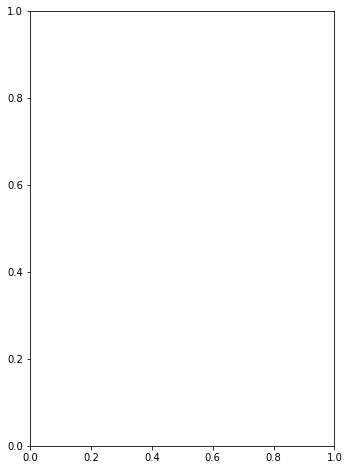

In [8]:
### Plot losses
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax1.semilogy(train_loss_adam, label='Train loss')
ax1.semilogy(val_loss_adam, label='Validation loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.semilogy(accuracy_adam, label = "Test accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Test accuracy (%)")

plt.tight_layout()
plt.show()

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net.state_dict(),
            "parameters" : parameters}
# Save the state dict to a file
torch.save(net_dict,filename)


### Adam with L2 regularization

In [ ]:
# Define the network
filename = "ConvNet_adamL2.torch"
parameters = {
    "act" : nn.ReLU, 
    "drop_p" : 0.1,
}

# Inizialize the network
torch.manual_seed(0)
net = ConvNet(parameters)
net.to(device)

In [ ]:
# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr = 0.001, weight_decay = 0.1)

# Training 
max_num_epochs = 20
early_stopping = False
train_loss_adamL2, val_loss_adamL2, accuracy_adamL2 = train_epochs_acc(net, device, train_dataloader, val_dataloader, test_dataloader, loss_function, optimizer, max_num_epochs, early_stopping = early_stopping)


In [ ]:
### Plot losses
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax1.semilogy(train_loss_adamL2, label='Train loss')
ax1.semilogy(val_loss_adamL2, label='Validation loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.semilogy(accuracy_adamL2, label = "Test accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Test accuracy (%)")

plt.tight_layout()
plt.show()

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net.state_dict(),
            "parameters" : parameters}
# Save the state dict to a file
torch.save(net_dict,filename)


### Adagrad

In [ ]:
# Define the network
filename = "ConvNet_adagrad.torch"
parameters = {
    "act" : nn.ReLU, 
    "drop_p" : 0.1,
}

# Inizialize the network
torch.manual_seed(0)
net = ConvNet(parameters)
net.to(device)

In [ ]:
# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adagrad(net.parameters(), lr = 0.1, lr_decay = 0.1, weight_decay = 0.0)

# Training 
max_num_epochs = 20
early_stopping = True
train_loss_adagrad, val_loss_adagrad, accuracy_adagrad = train_epochs_acc(net, device, train_dataloader, val_dataloader, test_dataloader, loss_function, optimizer, max_num_epochs, early_stopping = early_stopping)


In [ ]:
### Plot losses
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax1.semilogy(train_loss_adagrad, label='Train loss')
ax1.semilogy(val_loss_adagrad, label='Validation loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.semilogy(accuracy_adagrad, label = "Test accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Test accuracy (%)")

plt.tight_layout()
plt.show()

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net.state_dict(),
            "parameters" : parameters}
# Save the state dict to a file
torch.save(net_dict,filename)


### Comparision

In [ ]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(131)
ax1.set_title("Training losses")
ax1.semilogy(train_loss_sgd, label='SGD')
ax1.semilogy(train_loss_sgdmom, label='SGD with momentum')
ax1.semilogy(train_loss_rmsprop, label='RMSprop')
ax1.semilogy(train_loss_adam, label='Adam')
ax1.semilogy(train_loss_adamL2, label='Adam with L2')
ax1.semilogy(train_loss_adagrad, label='Adagrad')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(132)
ax2.set_title("Validation losses")
ax2.semilogy(val_loss_sgd, label='SGD')
ax2.semilogy(val_loss_sgdmom, label='SGD with momentum')
ax2.semilogy(val_loss_rmsprop, label='RMSprop')
ax2.semilogy(val_loss_adam, label='Adam')
ax2.semilogy(val_loss_adamL2, label='Adam with L2')
ax2.semilogy(val_loss_adagrad, label='Adagrad')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.grid()
ax2.legend()


ax3 = fig.add_subplot(133)
ax3.set_title("Accuracies")
ax3.semilogy(accuracy_sgd, label='SGD')
ax3.semilogy(accuracy_sgdmom, label='SGD with momentum')
ax3.semilogy(accuracy_rmsprop, label='RMSprop')
ax3.semilogy(accuracy_adam, label='Adam')
ax3.semilogy(accuracy_adamL2, label='Adam with L2')
ax3.semilogy(accuracy_adagrad, label='Adagrad')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('%')
ax3.grid()
ax3.legend()

fig.savefig("class_optim_compar.png")
plt.tight_layout()
plt.show()

## Hyperparameter optimization:
### Optuna framework

In [13]:

# Define objective function
def objective(trial):
    
    # Define objects to be optimized
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    activation_name = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU"])
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-1, log = True)
    momentum = trial.suggest_float("momentum", 0.0, 1.0)
    drop_p = trial.suggest_float("dropout", 0.0, 1.0)
    
    parameters = {
    "act" : getattr(nn, activation_name), 
    "drop_p" : drop_p,
    }

    # Define the model
    model = ConvNet(parameters)
   
    # Define the optimizer
    if optimizer_name == "Adam":
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    else:
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr, momentum = momentum)
        
    # Define the loss function 
    loss_function = nn.CrossEntropyLoss()
    
    max_num_epochs = 10
    early_stopping = False
    train_loss, val_loss, accuracy = train_epochs_acc(model, device, train_dataloader, val_dataloader, test_dataloader, loss_function, optimizer, max_num_epochs, early_stopping = early_stopping)
    
    # Metric to be minimized is the last validation loss
    return val_loss[-1]


In [14]:
study = optuna.create_study()
study.optimize(objective, n_trials= 20)

study.best_params  

[I 2022-02-10 11:23:36,389] A new study created in memory with name: no-name-85eb2ce7-07cc-45c1-9c5c-e85ea17598a1


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plot_parallel_coordinate(study)

In [ ]:
plot_param_importances(study)

## Best model

In [ ]:
# Define the network
filename = "ConvNet_best.torch"
parameters = {
    "act" : nn.ReLU, 
    "drop_p" : 0.1,
}


# Inizialize the network
torch.manual_seed(0)
net = ConvNet(parameters)
net.to(device)

In [ ]:
# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.RMSprop(net.parameters(), lr = 0.0094722414675771641, momentum = 0.6653025986790503 , weight_decay = 0.22302174896930235)

# Training 
max_num_epochs = 20
early_stopping = True
train_loss_best, val_loss_best, accuracy_best = train_epochs_acc(net, device, train_dataloader, val_dataloader, test_dataloader, loss_function, optimizer, max_num_epochs, early_stopping)


In [ ]:
### Plot losses
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax1.semilogy(train_loss_best, label='Train loss')
ax1.semilogy(val_loss_best, label='Validation loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.semilogy(accuracy_best, label = "Test accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Test accuracy (%)")

plt.tight_layout()
plt.show()
fig.savefig("best_model.png")

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net.state_dict(),
            "parameters" : parameters}
# Save the state dict to a file
torch.save(net_dict,filename)

## K-fold cross validation
Train the network with best hyperparameters found with optuna before with k-fold cross validation 

In [15]:
# Define the network
filename = "ConvNet_kfold_learned.torch"
parameters = {
    "act" : nn.ReLU, 
    "drop_p" : 0.1,
}

# Inizialize the network
torch.manual_seed(0)
net = ConvNet(parameters)
net.to(device)

# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr = 0.0001 , weight_decay = 0.22302174896930235)


Network initialized


In [16]:

# K-fold cross validation training
max_num_epochs = 20
early_stopping = True
mean_train_loss, std_train_loss, mean_val_loss, std_val_loss = kf_train_epochs(net, device, 3, 128, dataset, test_dataloader, loss_function, optimizer, max_num_epochs, early_stopping = early_stopping)


  0%|          | 0/20 [00:00<?, ?it/s]

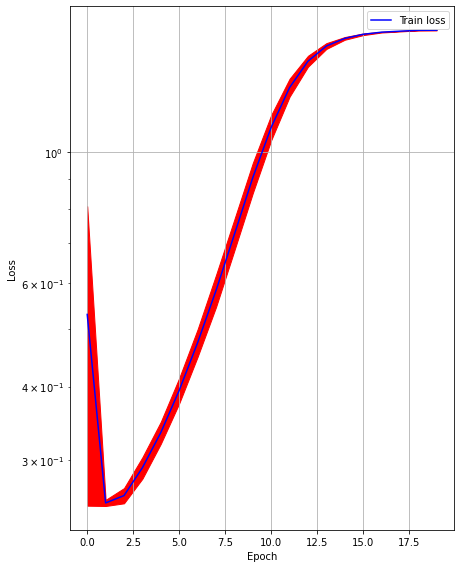

In [20]:
### Plot k-fold losses


fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax1.semilogy(mean_train_loss, c = "b", label='Train loss')
ax1.fill_between(np.array(range(max_num_epochs)), np.subtract(mean_train_loss,std_train_loss), np.add(mean_train_loss,std_train_loss), color = "r")
#ax1.semilogy(mean_val_log, label='Validation loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()


plt.tight_layout()
plt.show()

## Network analysis

In [ ]:
### Load network state
filename = "ConvNet_adam.torch"

# Load the state dict previously saved
net_dict = torch.load(filename)
net_state_dict = net_dict["state"]
net_parameters_dict = net_dict["parameters"]

# Redefine the network and upload parameters
net = ConvNet(net_parameters_dict)
net.load_state_dict(net_state_dict)

### Accuracy
    
    

In [ ]:
### Compute accuracy of the model
mismatched, confusion, acc = my_accuracy(net, device, test_dataloader)
print("Test accuracy: ", acc, "%")

### Plot mismatched numbers


In [ ]:
# Plot Mismatched numbers
figure = plt.figure(figsize=(8, 8))
cols, rows = 4,4


for i in range(rows*cols):
    img = mismatched[i][0]
    
    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray"  )
    plt.title("Predicted: "+str(mismatched[i][1])+"\n"+"True: "+str(mismatched[i][2]))
    
plt.tight_layout()
plt.show()

### Confusion matrix

In [ ]:
### Build the confusion matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

# Get predictions and ground trues
trues = confusion[0]
predictions = confusion[1]

# Compute and plot confusion matrix
cm = confusion_matrix(trues, predictions, labels =np.array(range(10)) )
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = np.array(range(10)))
disp.plot()
plt.show()


## Network parameters 

In [ ]:
# Access convolution network parameters

dense_weight = net.lin[0].weight.data.cpu().numpy()
dense_bias = net.lin[0].bias.data.cpu().numpy()
out_weight = net.lin[3].weight.data.cpu().numpy()
out_bias = net.lin[3].bias.data.cpu().numpy()

### Convolution filtered images

In [ ]:
# Acces convolution filters
conv1 = net.cnn[0].weight.data.cpu()
conv2 = net.cnn[5].weight.data.cpu()

In [ ]:
### First convolution filter
fig = plt.figure(figsize=(8, 8))
cols, rows = 4,4

# Take an image and apply convolution
img, label = train_data[35]
img = F.conv2d(img.unsqueeze(dim=0), conv1)


# Plot filtered images

for i in range(16):
    fig.add_subplot(rows, cols, i+1)
    plt.axis("off")
    #plt.title("Filter %d" %(i+1))
    plt.imshow(img.squeeze().numpy()[i], cmap="gray")
    
plt.tight_layout()
plt.show()




In [ ]:
### Second convolution filter
fig = plt.figure(figsize=(8, 8))
cols, rows = 8,4

# Take an image and apply convolution
img, label = train_data[9]
img = F.conv2d(img.unsqueeze(dim=0), conv1)
img = F.relu(img)
img  = F.max_pool2d(img, kernel_size = 2)
img = F.conv2d(img, conv2)

# Plot filtered images

for i in range(32):
    fig.add_subplot(rows, cols, i+1)
    plt.axis("off")
    #plt.title("Filter %d" %(i+1))
    plt.imshow(img.squeeze().numpy()[i], cmap="gray")
    
plt.tight_layout()
plt.show()